# SMS Spam Classification

This project I will be looking into SMS text data from multiple sources all collected by the team [Tiago A. Almeida](http://dcomp.sor.ufscar.br/talmeida/) and [José María Gómez Hidalgo](http://www.esp.uem.es/jmgomez). For more information on how they collected this data check it out [here](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/).

Some notable sources used while performing this analysis and classification: 
- [Ultimate guide to deal with Text Data (using Python)](https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/)

The data here is a collection of 747 Spam texts along with 4,827 non-spam (HAM) texts. The file is formatted as a plain text file.



In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
import spacy
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
np.random.seed(0)
%matplotlib inline

### Read in the file. 

from exploring the data we know that we need to strip the new line characters (__\n__) and that the message and label are separated by a tab (__\t__).

In [2]:
with open('Data/SMSSpamCollection.txt') as f:
    lines = [line.rstrip('\n').split('\t') for line in f]

In [3]:
sms_df = pd.DataFrame(lines)

In [4]:
sms_df.head()
sms_df.shape

(5574, 2)

In [5]:
#rename the columns
sms_df.rename(columns={0:'label', 1:'text'},inplace=True)

le = LabelEncoder()
sms_df['target'] = le.fit_transform(sms_df['label'])

In [6]:
sms_df.head(3)

,label,text,target
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1


### Basic Feature Engineering

Before any of this I did a little bit of text exploring to see if I could see anything that may or may not help me--this was crucial for choosing __'flag words'__. Items like word count, char counts, number of numerics, number of upper case, etc. are pretty common practice, so they are great features to add to your data set before cleaning. 

1. word count
2. character count
3. Number of numerics
4. Number of upper case
5. Number of Exclamation Points (!)
6. Number of Flag Words
7. Links in message
8. Count of stop words


__ 1. word count__

In [7]:
sms_df['word_count'] = sms_df.text.apply(lambda x: len(str(x).split(' ')))

__2. character count__

In [8]:
sms_df['char_count'] = sms_df.text.str.len() #this includes the spaces

__3. Number of numerics__

In [9]:
sms_df['numerics'] = sms_df.text.apply(lambda x: len([x for x in x.split() if x.isdigit()]))

__4. Number of upper case characters__

this returns how many words in the message are all-caps

In [10]:
sms_df['upper'] = sms_df.text.apply(lambda x: len([x for x in x.split() if x.isupper()]))

__5. Number of Excalmation Points (!)__

This splits the message a returns how many times the message has been split minus 1. This will return the total number of '!' in the message. e.g. if we have a message: 'Hey!' it will return ['Hey',''], so we subtract one to get # of excalamtion points.

In [11]:
sms_df['bangs'] = sms_df.text.apply(lambda x: len([x for x in x.split('!')]) - 1 )

__6. Flag Words__

Shout-out to [Grace](https://github.com/graceh3) for this idea! 

Possible __"flag"__ words from looking at the first few rows of data:

In [12]:
sms_df['flag_words'] = sms_df.text.apply(lambda x: len([x for x in x.split(' ') 
                                                        if x.translate(str.maketrans('', '', string.punctuation)).lower().strip() 
                                                        in ['winner','urgent','win','won','free','cash','freemsg',
                                                            'stopsms','ppm']]))


__7. Links in message__

We will use regex to be able to see if there are any links in the message

In [13]:
p = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

sms_df['links'] = sms_df.text.apply(lambda x: len(re.findall(p, x))) + sms_df.text.apply(lambda x: x.count('.com')+x.count('.co')+x.count('.uk'))



In [14]:
sms_df.links.sum()

276

In [15]:
sms_df[sms_df['links'] >= 1].head()

,label,text,target,word_count,char_count,numerics,upper,bangs,flag_words,links
15,spam,"XXXMobileMovieClub: To use your credit, click ...",1,19,149,0,1,0,0,3
136,ham,I only haf msn. It's yijue@hotmail.com,0,6,38,0,1,0,0,2
191,spam,Are you unique enough? Find out from 30th Augu...,1,10,72,0,0,0,0,2
250,spam,Congratulations ur awarded 500 of CD vouchers ...,1,23,150,4,2,0,1,2
268,spam,Ur ringtone service has changed! 25 Free credi...,1,27,159,1,5,3,1,2


__8. Count of Stop Words__

these are words that don't add any real value to our messages, which include: of, the, on, etc. Without them our sentences would not be great, but they don't impact meaning in the long run.

In [16]:
stop = stopwords.words('english')

sms_df['stp_wrd_cnt'] = sms_df.text.apply(lambda x: len([x for x in x.split() if x in stop]))

__Lets look at the first few columns to see how all these new columns look__

So far, these engineered columns are looking _great!_ They should have a big impact on our spam predicting.

In [17]:
sms_df.head()

,label,text,target,word_count,char_count,numerics,upper,bangs,flag_words,links,stp_wrd_cnt
0,ham,"Go until jurong point, crazy.. Available only ...",0,20,111,0,0,0,0,0,4
1,ham,Ok lar... Joking wif u oni...,0,6,29,0,0,0,0,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,28,155,2,2,0,2,0,5
3,ham,U dun say so early hor... U c already then say...,0,11,49,0,2,0,0,0,2
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,13,61,0,1,0,0,0,5


### Data Preprocessing

Next, we need to move into data cleaning. This section will be very important for the remaineder of this project and the models we run. In the next few cells we will:
1. create a function to remove all punction
2. lower case all of the words in our messages
3. remove stop words
4. check for spelling and correct where needed
5. remove frequent
6. remove rare/uncommon words


#### 1) and 2) get rid of special charaters and lower case:

In [18]:
def clean_text_column(row):
    import string
    '''
    takes in a cell from the dataframe and removes all of the symbols from 
    string.punctuation ('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'), and then lower
    cases each line.
    '''
    return row.translate(str.maketrans('', '', string.punctuation)).lower()

In [19]:
sms_df.text = sms_df.text.apply(lambda row: clean_text_column(row))

Check what our function did:

In [20]:
print(sms_df.text.iloc[2],sms_df.iloc[2],sep='\n\n')

free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s

label                                                       spam
text           free entry in 2 a wkly comp to win fa cup fina...
target                                                         1
word_count                                                    28
char_count                                                   155
numerics                                                       2
upper                                                          2
bangs                                                          0
flag_words                                                     2
links                                                          0
stp_wrd_cnt                                                    5
Name: 2, dtype: object


#### 3. Remove all stop words:

Here we will remove all of the words that do not add value to the meaning of our messages.

In [21]:
stop = stopwords.words('english') #loads the stop words for the english language
sms_df.text = sms_df.text.apply(lambda x: " ".join(x for x in x.split() if x not in stop)) 
#returns only words that are not in the list of stop words

#### 4. Correct Obvious Spelling issues:

First, lets fix the most commonly 'missspelled' words. After, we will use textBlob to correct our spelling for all the other ones.

In [22]:
#most common word list:
common_w = pd.Series(' '.join(sms_df.text).split()).value_counts()[:50]
common_w 

u         1132
call       578
2          482
im         464
ur         390
get        386
4          293
dont       287
go         281
ok         278
ltgt       276
free       275
know       257
like       244
got        239
ill        239
good       236
come       229
time       208
day        203
love       200
want       193
send       191
text       188
going      171
one        171
ü          169
need       167
txt        163
home       162
lor        160
see        157
sorry      156
still      154
r          153
back       152
stop       152
n          146
reply      144
today      141
mobile     138
tell       137
new        136
well       134
later      134
hi         133
think      132
da         131
please     129
take       126
dtype: int64

A good amount of these are abbreviations, so lets change these in our dataset before we remove frequent and rare words.

In [23]:
rep = {' wif u ':' with you ', ' u r ':' you are ', 'ic': ' i see ', ' i c ': ' i see ',
       ' u c ': ' you see ',' u ':' you ',' n ':' and ',' r ':' are ',' txt ':' text ',
       ' ü ':' you ',' 4 ':' for ',' 2 ':' to ',' ur ':' your ',' da ':' the ',' wif ':' with ',
       ' urself ':' yourself ', ' thats ': ' thats ', ' i‘m ': ' im ', '£':''}

pattern = re.compile("|".join(rep.keys()))
sms_df.text = sms_df.text.apply(lambda x: pattern.sub(lambda m: rep[m.group(0)], x.center(len(x)+2)).strip())
# text = pattern.sub(lambda m: rep[m.group(0)], x.center(len(x)+2)).strip()

__Now if we look at the most common words, we can see the changes that we have made__

In [24]:
common_w = pd.Series(' '.join(sms_df.text).split()).value_counts()[:50]
common_w 

you       1203
see        961
i          794
call       578
im         469
to         464
get        386
your       349
text       346
e          320
for        287
dont       287
go         281
ok         278
ltgt       276
free       275
know       257
like       244
ill        239
got        239
good       236
come       229
time       208
k          207
day        203
love       200
want       193
send       191
going      171
one        171
need       167
home       162
lor        160
sorry      157
still      154
back       152
stop       152
are        149
p          146
reply      144
today      141
and        141
mobile     138
tell       137
new        136
later      134
well       134
hi         133
think      132
please     129
dtype: int64

#### 5. Remove Very Frequent Words:
Super common words do not add value to their connection with other words, which is why we will remove the top ten most common words in the cell below. Becuase this is text data, I decided it would be fine in this case to remove these words. [Here](https://www.quora.com/Why-do-we-remove-frequent-and-infrequent-words-when-in-NLP) is a great explaination for this.

In [25]:
#most common word list:
common_w = pd.Series(' '.join(sms_df.text).split()).value_counts()[:15]
#Pretty good sign that most of these seem like filler words

In [26]:
#now that we've checked on them, lets remove them from our texts
sms_df.text = sms_df.text.apply(lambda x: ' '.join(x for x in x.split() if x not in list(common_w.index)))

#### 6. Use SymSpell to correct spelling: 

Now that we've removed a good portion of words that add noise to our data, we should clean up the words in one final step to correct spelling. 

There are many libraries to do this, but this one is very quick and compared to others I've used appears to be very accurate. We will correct the spelling of words that occur once.

In [27]:
from symspellpy.symspellpy import SymSpell
sym_spell = SymSpell(2, 7)
sym_spell.load_dictionary('frequency_dictionary_en_82_765.txt', 0, 1)

True

In [28]:
#list of words that only occur once:
word_lists = list(sms_df.text.apply(lambda x: x.split(' ')))
all_words = [word for rev in word_lists for word in rev]
corpus_word_counts_df = pd.DataFrame(pd.Series(all_words).value_counts()).reset_index()\
.rename(columns={'index':'words',0:'counts'})

In [29]:
corpus_word_counts_df_1 = corpus_word_counts_df[corpus_word_counts_df['counts'] == 1]

In [30]:
from tqdm._tqdm_notebook import tqdm_notebook

tqdm_notebook.pandas(desc="Progress: ")

corpus_word_counts_df_1['corrected'] = corpus_word_counts_df_1.words.progress_apply(lambda w: 
                                                                                     sym_spell.word_segmentation(w)[0])

/Users/elenasm7/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Replace words that were corrected in this last step by applying the function we're defining below:

In [31]:
def replace_fixed_words(message,df):
    words = message.split(' ')
    cor_rev = []
    for word in words: 
        if word in list(df.words):
            cor_rev.append(df[df['words'] == word]['corrected'].item())
        else:
            cor_rev.append(word)
    return ' '.join(cor_rev)

In [32]:
sms_df['text_corr'] = sms_df\
.text.progress_apply(lambda x: replace_fixed_words(x,corpus_word_counts_df_1))

In [33]:
sms_df.to_csv('Data/spelling_and_features_sms.csv')
# sms_df = pd.read_csv('Data/spelling_and_features_sms.csv')

### Lemmatizing:

I originally planned on using NLTK amd the part of speech to lemmatize. However, I later discovered Spacy, which is very efficient and accurate. They have amazing [documentation](https://spacy.io/api/annotation#lemmatization) for lemmatizing and everything else the librazry offers, which is _a lot_. 

__Here is a little information on what I previously planned on doing, along with some great articles to help:__

Great article [here](https://www.datacamp.com/community/tutorials/stemming-lemmatization-python) about lemmatizing and stemming with NLTK.

If you get an error about POS (part of speech) tagging, then you may need to download treebank and punkt from NLTK. [Here](https://stackoverflow.com/questions/14089887/nltk-pos-tag-usage) is the resource I used. However, mine did not work until I downloaded 'averaged_perceptron_tagger'.

Below I defined a function that takes the returned pos values from nltk.pos_tag, and returns a compatible version of them. This was a great solution on [stackoverflow](https://stackoverflow.com/questions/5364493/lemmatizing-pos-tagged-words-with-nltk).


In [33]:
def return_lemma(review,nlp):
    doc = nlp(review)
    return ' '.join([word.lemma_ for word in doc])
    

In [34]:
nlp = spacy.load("en_core_web_sm")
sms_df['lemmed']=sms_df.text.apply(lambda txt: return_lemma(txt,nlp))


In [35]:
sms_df.lemmed[:10]

0    jurong point crazy available bugi and great wo...
1                                    lar joke with oni
2    free entry wkly comp win fa cup final tkts 21s...
3                        dun say early hor already say
4                  nah think go usf life around though
5    freemsg hey darle 3 week word back -PRON- woul...
6        even brother like speak treat like aid patent
7    per request melle melle oru minnaminunginte nu...
8    winner value network customer select receivea ...
9    mobile 11 month be entitle update late colour ...
Name: lemmed, dtype: object

### Tokenize the words in each message

below we will use the nltk word tokenizer to accomplish this. This function will train-test split our data. We are setting a random state of 40. I have also chosen to do a 80/20 split based on the pareto principle.

First, let's split up our columns into predictors (X) and Targets. For this we will have two separate sets of predictors. X1 will be just the corrected text and X2 will be everything else except for texts.

In [36]:
X1 = sms_df.lemmed
X2 = sms_df.iloc[:,3:11]
y = sms_df.target

__Let us train-test split the non-text predictors using the same parameters (test_size and random_state)__

In [37]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2, y, test_size=0.20, random_state=42)

In [38]:
def tfidf(X, y): 
    '''
    Generate train and test TF-IDF vectorization for our data set
    
    Parameters
    ----------
    X: pandas.Series object
        Pandas series of text documents to classify 
    y : pandas.Series object
        Pandas series containing label for each document
    Returns
    --------
    tf_idf_train :  sparse matrix, [n_train_samples, n_features]
        Vector representation of train data
    tf_idf_test :  sparse matrix, [n_test_samples, n_features]
        Vector representation of test data
    y_train : array-like object
        labels for training data
    y_test : array-like object
        labels for testing data
    vectorizer : vectorizer object
        fit TF-IDF vecotrizer object

    '''
    
    from sklearn.model_selection import train_test_split
    from sklearn.feature_extraction.text import TfidfVectorizer
    vectorizer = TfidfVectorizer()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    tf_idf_train = vectorizer.fit_transform(X_train)
    tf_idf_test = vectorizer.transform(X_test)
    return tf_idf_train,tf_idf_test, y_train, y_test, vectorizer

In [39]:
tf_idf_train,tf_idf_test, y_train, y_test, vectorizer = tfidf(X1, y)

### Predictions: 

Next, I will use muliple models to predict if the message is spam or not. After I will take the average of the results and make the final prediction.

__First lets do it just for the tf-idf matrix:__

I have defined a function called "classify_text", you pass it the classifier, tf_idf_train, tf_idf_test, and y_train and it will return the predictions for train and test.

In [40]:
def classify_text(classifier, tf_idf_train, tf_idf_test, y_train):
    '''
    Train a classifier to identify whether a message is spam or ham
    
    Parameters
    ----------
    classifier: sklearn classifier
       initialized sklearn classifier (MultinomialNB, RandomForestClassifier, etc.)
    tf_idf_train : sparse matrix, [n_train_samples, n_features]
        TF-IDF vectorization of train data
    tf_idf_test : sparse matrix, [n_test_samples, n_features]
        TF-IDF vectorization of test data
    y_train : pandas.Series object
        Pandas series containing label for each document in the train set
    Returns
    --------
    train_preds :  list object
        Predictions for train data
    test_preds :  list object
        Predictions for test data
    '''
    clf = classifier
    clf.fit(tf_idf_train, y_train)
    return clf.predict(tf_idf_train), clf.predict(tf_idf_test)

Initalize a random forest classifier and then pass the sbove function the correct objects:

In [41]:
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_train_preds, rf_test_preds = classify_text(rf_classifier,tf_idf_train, tf_idf_test, y_train)

In [42]:
print(confusion_matrix(y_test, rf_test_preds))
print(accuracy_score(y_test, rf_test_preds))

[[951   3]
 [ 25 136]]
0.9748878923766816


#### Our random forest classifier is very accurate. We could definitly just stop here, however lets try to make it even better!

First we will create models for the predictors, after we should use gridsearch to tune the random forest hyperparameters.

So, create the model for our other predictors:

In [44]:
scaler = MinMaxScaler()

X_train_2[['word_count', 'char_count', 'numerics', 'upper', 'bangs', 'flag_words',
       'links', 'stp_wrd_cnt']] = scaler.fit_transform(X_train_2[['word_count', 'char_count', 'numerics', 'upper', 'bangs', 'flag_words',
       'links', 'stp_wrd_cnt']])

/Users/elenasm7/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/elenasm7/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/elenasm7/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Now, create a baseline logistic regression model:

In [46]:
logreg = LogisticRegression(fit_intercept = False, C = 1e12)

model_log = logreg.fit(X_train_2, y_train_2)
model_log

/Users/elenasm7/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

#### Transform the test data and then make our predictions:

In [47]:
X_test_2[['word_count', 'char_count', 'numerics', 'upper', 'bangs', 'flag_words',
       'links', 'stp_wrd_cnt']] = scaler.fit_transform(X_test_2[['word_count', 'char_count', 'numerics', 'upper', 'bangs', 'flag_words',
       'links', 'stp_wrd_cnt']])

/Users/elenasm7/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/elenasm7/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/elenasm7/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-cop

In [48]:
y_hat_train = logreg.predict(X_train_2)
y_hat_test = logreg.predict(X_test_2)

Now, lets see how well this predictor did:

In [58]:
# for training data
conf_mat_train = confusion_matrix(y_train_2, y_hat_train)
acc_train = accuracy_score(y_train_2, y_hat_train)

print('Training Data confusion matrix:',conf_mat_train,'\nTraining Accuracy:',acc_train,sep='\n')

#for testing data
conf_mat_test = confusion_matrix(y_test_2, y_hat_test)
acc_test = accuracy_score(y_test_2, y_hat_test)
print('\n','Testing Data confusion matrix:',conf_mat_test,'\nTesting Accuracy',acc_test,sep='\n')


Training Data confusion matrix:
[[3614  259]
 [ 186  400]]

Training Accuracy:
0.9002018389773492


Testing Data confusion matrix:
[[915  39]
 [ 78  83]]

Testing Accuracy
0.895067264573991


In [64]:
y_hat_test_rf = pd.Series(rf_test_preds)
y_hat_test_s = pd.Series(y_hat_test)

In [72]:
testing_preds_df = pd.DataFrame(y_hat_test,rf_test_preds)

In [75]:
testing_preds_df.reset_index(inplace=True)

In [77]:
rf_acc = accuracy_score(y_test, rf_test_preds)
acc_test

0.895067264573991

In [78]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
clf.fit(X_train_2, y_train_2)  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [81]:
y_hat_train_rf_2 = clf.predict(X_train_2)
y_hat_test_rf_2 = clf.predict(X_test_2)

In [129]:
# for training data
conf_mat_train = confusion_matrix(y_train_2, y_hat_train_rf_2)
acc_train = accuracy_score(y_train_2, y_hat_train_rf_2)
train_f1_score = f1_score(y_train_2, y_hat_train_rf_2)

print('Training Data confusion matrix:',conf_mat_train,'\nTraining Accuracy:',acc_train,
      '\nf1_score:',train_f1_score,sep='\n')

#for testing data
conf_mat_test = confusion_matrix(y_test_2, y_hat_test_rf_2)
acc_test = accuracy_score(y_test_2, y_hat_test_rf_2)
test_f1_score = f1_score(y_test_2, y_hat_test_rf_2)
print('\n','Testing Data confusion matrix:',conf_mat_test,'\nTesting Accuracy:',acc_test,
      '\nf1_score:',test_f1_score,sep='\n')

Training Data confusion matrix:
[[3867    6]
 [ 320  266]]

Training Accuracy:
0.9268894370935187

f1_score:
0.62004662004662


Testing Data confusion matrix:
[[951   3]
 [ 90  71]]

Testing Accuracy:
0.9165919282511211

f1_score:
0.6042553191489362


One thing to explore: __Class Imbalance__
    
Lets look at the class dispersion between spam and not-spam:

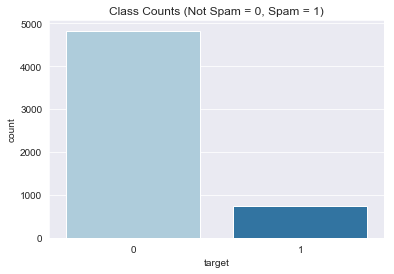

In [101]:
sns.countplot(y,palette="Paired")
sns.set_style(style='darkgrid')
plt.title("Class Counts (Not Spam = 0, Spam = 1)");

Due to how many normal texts we have vs. spam texts, our model may be predicting normal texts more often than not. To help address this we can over or undersample our train data, and then refit our model. There are some pros and cons to oversampling, however for this project I have decided to do SMOTE or synthetic over sampling. 

This is Synthetic becuase it simply resamples the data multiple times.

We can explicity define the type of over sampling we are doing. However, it automatically oversamples the minority class, which is what we need.

In [104]:
from imblearn.over_sampling import SMOTE

In [105]:
sm = SMOTE(random_state=42)

In [106]:
X_res, y_res = sm.fit_resample(X_train_2, y_train_2)

In [110]:
X_res_df = pd.DataFrame(X_res,columns=X_train_2.columns)

#### Lets checkout what the countplot looks like now:

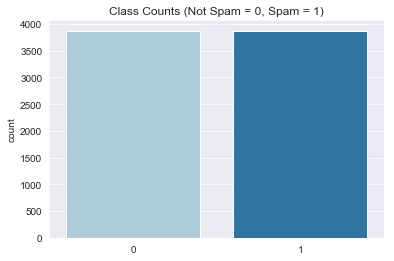

In [113]:
sns.countplot(y_res,palette="Paired")
sns.set_style(style='darkgrid')
plt.title("Class Counts (Not Spam = 0, Spam = 1)");

It is completely even now, great! Now, lets refit our classifier and see how it does.

In [114]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
clf.fit(X_res, y_res) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [115]:
y_hat_train_rf_res = clf.predict(X_res)
y_hat_test_rf_res = clf.predict(X_test_2)

In [128]:
# for training data
conf_mat_train = confusion_matrix(y_res, y_hat_train_rf_res)
acc_train = accuracy_score(y_res, y_hat_train_rf_res)
train_f1_score = f1_score(y_res, y_hat_train_rf_res)
print('Training Data confusion matrix:',conf_mat_train,'\nTraining Accuracy:',acc_train,
      '\nf1_score:',train_f1_score,sep='\n')

#for testing data
conf_mat_test = confusion_matrix(y_test_2, y_hat_test_rf_res)
acc_test = accuracy_score(y_test_2, y_hat_test_rf_res)
test_f1_score = f1_score(y_test_2, y_hat_test_rf_res)
print('\n','Testing Data confusion matrix:',conf_mat_test,'\nTesting Accuracy:',acc_test,
      '\nf1_score:',test_f1_score,sep='\n')

Training Data confusion matrix:
[[3471  402]
 [ 410 3463]]

Training Accuracy:
0.8951717015233669

f1_score:
0.8950633238562936


Testing Data confusion matrix:
[[786 168]
 [ 15 146]]

Testing Accuracy:
0.8358744394618834

f1_score:
0.6147368421052631


__So far, it looks like the oversampling did not have a positive affect on our classifier. We can try an undersampling technique to see if this has an impact.__

#### So, lets use ClusterCentroids from imblearn.under_sampling to resample our original train data:

In [117]:
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=0)
X_resampled, y_resampled = cc.fit_resample(X_train_2, y_train_2)

__Lets see what this looks like:__

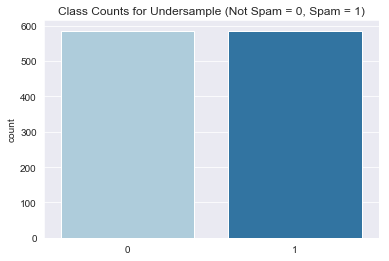

In [118]:
sns.countplot(y_resampled,palette="Paired")
sns.set_style(style='darkgrid')
plt.title("Class Counts for Undersample (Not Spam = 0, Spam = 1)");

We went from roughly ~4000 records of each class to ~600 of each. We are working with significantly less data, which may have a negative impact on our classifier. 

#### Let's try it out now:

In [120]:
clf.fit(X_resampled, y_resampled) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [121]:
y_hat_train_us = clf.predict(X_resampled)
y_hat_test_us = clf.predict(X_test_2)

In [126]:
# for training data
conf_mat_train = confusion_matrix(y_resampled, y_hat_train_us)
acc_train = accuracy_score(y_resampled, y_hat_train_us)
train_f1_score = f1_score(y_resampled, y_hat_train_us)

print('Training Data confusion matrix:',conf_mat_train,'\nTraining Accuracy:',acc_train,
      '\nf1_score:',train_f1_score,sep='\n')

#for testing data
conf_mat_test = confusion_matrix(y_test_2, y_hat_test_us)
acc_test = accuracy_score(y_test_2, y_hat_test_us)
test_f1_score = f1_score(y_test_2, y_hat_test_us)
print('\n','Testing Data confusion matrix:',conf_mat_test,'\nTesting Accuracy:',acc_test,
      '\nf1_score:',test_f1_score,sep='\n')

Training Data confusion matrix:
[[482 104]
 [ 97 489]]

Training Accuracy:
0.8284982935153583

f1_score:
0.8295165394402035


Testing Data confusion matrix:
[[906  48]
 [ 99  62]]

Testing Accuracy:
0.8681614349775785

f1_score:
0.4575645756457565


Taking away these records seems to have negatively impacted the accuracy of our classifier. So, we will return to the original data, and try hyperparameter tuning.